In [3]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

Credits to https://github.com/google-research/rliable

In [16]:
# pip install matplotlib
!pip install pandas
!pip install seaborn 
!pip install rliable



[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 2.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 9.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 43.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 44.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 27.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [17]:
import json
import math
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator
from matplotlib import rcParams
from matplotlib import rc
import numpy as np
import pandas as pd
import seaborn as sns

from rliable import library as rly
from rliable import metrics
from rliable import plot_utils

rcParams['legend.loc'] = 'best'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rc('text', usetex=False)
RAND_STATE = np.random.RandomState(42)
sns.set_style("white")

Path('figures').mkdir(exist_ok=True, parents=False)

In [20]:
def score_normalization(res_dict, min_scores, max_scores):
    games = res_dict.keys()
    norm_scores = {}
    for game, scores in res_dict.items():
        norm_scores[game] = (scores - min_scores[game])/(max_scores[game] - min_scores[game])
    return norm_scores

def convert_to_matrix(score_dict):
    keys = sorted(list(score_dict.keys()))
    return np.stack([score_dict[k] for k in keys], axis=1)

In [21]:
StratifiedBootstrap = rly.StratifiedBootstrap

IQM = lambda x: metrics.aggregate_iqm(x) # Interquartile Mean
OG = lambda x: metrics.aggregate_optimality_gap(x, 1.0) # Optimality Gap
MEAN = lambda x: metrics.aggregate_mean(x)
MEDIAN = lambda x: metrics.aggregate_median(x)

In [22]:
ATARI_100K_GAMES = [
    'Alien', 'Amidar', 'Assault', 'Asterix', 'BankHeist', 'BattleZone',
    'Boxing', 'Breakout', 'ChopperCommand', 'CrazyClimber', 'DemonAttack',
    'Freeway', 'Frostbite', 'Gopher', 'Hero', 'Jamesbond', 'Kangaroo',
    'Krull', 'KungFuMaster', 'MsPacman', 'Pong', 'PrivateEye', 'Qbert',
    'RoadRunner', 'Seaquest', 'UpNDown'
]

In [23]:
def read_curl_scores():
    df = pd.read_json('data/CURL_10_evals.json', orient='records')
    score_dict = {'Max': {}, 'Final': {}}
    for game in ATARI_100K_GAMES:
        game_df = df[df['game'] == game]
        score_dict['Final'][game] = game_df['HNS'].values
        score_dict['Max'][game] = game_df['Max HNS'].values
    score_matrices = {}
    for key, val in score_dict.items():
        score_matrices[key] = convert_to_matrix(val) 
    return score_dict['Final'], score_matrices['Final']
  
def load_json_scores(algorithm_name, normalize=True):
    path = Path('data') / f'{algorithm_name}.json'
    with path.open('r') as f:
        raw_scores = json.load(f)
    raw_scores = {game: np.array(val) for game, val in raw_scores.items()}
    if normalize:
        hn_scores = score_normalization(raw_scores, RANDOM_SCORES, HUMAN_SCORES)
        hn_score_matrix = convert_to_matrix(hn_scores)
    else:
        hn_scores, hn_score_matrix = None, None
    return hn_scores, hn_score_matrix, raw_scores

def save_fig(fig, name):
    fig.savefig(f'figures/{name}.pdf', format='pdf', bbox_inches='tight')

In [24]:
_, _, raw_scores_random = load_json_scores('RANDOM', normalize=False)
_, _, raw_scores_human = load_json_scores('HUMAN', normalize=False)
RANDOM_SCORES = {k: v[0] for k, v in raw_scores_random.items()}
HUMAN_SCORES = {k: v[0] for k, v in raw_scores_human.items()}

In [25]:
score_dict_muzero, score_muzero, raw_scores_muzero = load_json_scores('MuZero')
score_dict_efficientzero, score_efficientzero, raw_scores_efficientzero = load_json_scores('EfficientZero')
score_dict_simple, score_simple, _ = load_json_scores('SimPLe')
score_dict_curl, score_curl = read_curl_scores()
score_dict_drq_eps, score_drq_eps, _ = load_json_scores('DrQ(eps)')
score_dict_spr, score_spr, _ = load_json_scores('SPR')
score_dict_iris, score_iris, _ = load_json_scores('IRIS')

score_data_dict_games = {
    'MuZero': score_dict_muzero,
    'EfficientZero': score_dict_efficientzero,
    'SimPLe': score_dict_simple,
    'CURL': score_dict_curl,
    'DrQ': score_dict_drq_eps, 
    'SPR': score_dict_spr,
    'IRIS (ours)': score_dict_iris
}

all_score_dict = {
    'MuZero': score_muzero, 
    'EfficientZero': score_efficientzero,
    'SimPLe': score_simple,
    'CURL': score_curl,
    'DrQ': score_drq_eps, 
    'SPR': score_spr,
    'IRIS (ours)': score_iris
}

In [26]:
colors = sns.color_palette('colorblind')
xlabels = ['SimPLe', 'CURL', 'DrQ', 'SPR', 'IRIS (ours)']
color_idxs = [7, 4, 2, 1, 0]
ATARI_100K_COLOR_DICT = dict(zip(xlabels, [colors[idx] for idx in color_idxs]))

# Mean, Median, IQM and Optimality Gap

In [27]:
aggregate_func = lambda x: np.array([MEAN(x), MEDIAN(x), IQM(x), OG(x)])
aggregate_scores, aggregate_interval_estimates = rly.get_interval_estimates(all_score_dict, aggregate_func, reps=50000)

In [28]:
for algo in aggregate_scores.keys():
    n_runs, n_games = all_score_dict[algo].shape
    assert n_games == len(ATARI_100K_GAMES)
    print(f"{algo.ljust(14)}: {n_runs:3d} runs")

MuZero        :   1 runs
EfficientZero :   1 runs
SimPLe        :   5 runs
CURL          : 100 runs
DrQ           : 100 runs
SPR           : 100 runs
IRIS (ours)   :   5 runs


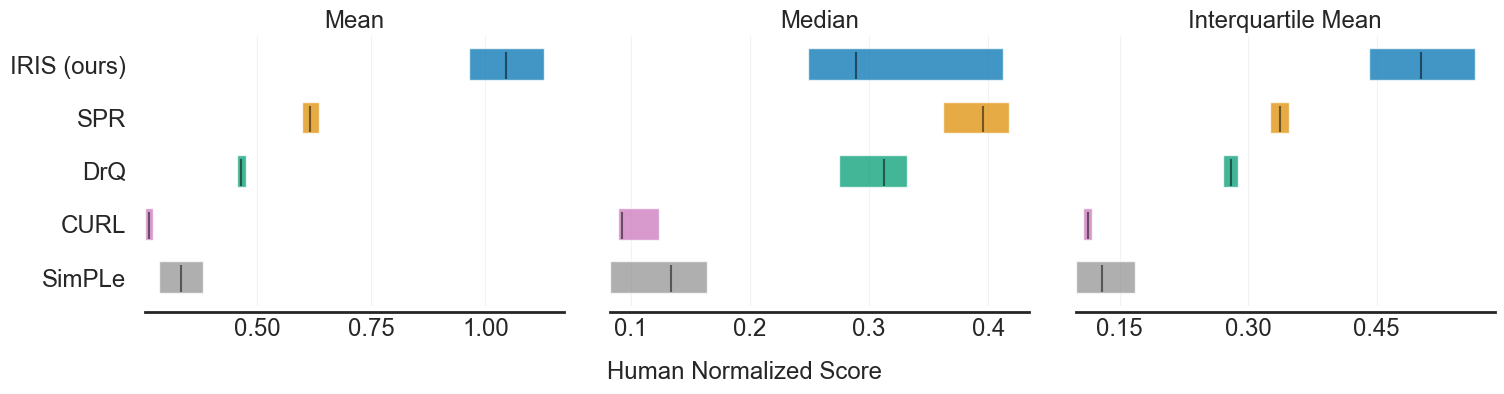

In [29]:
algorithms = ['SimPLe', 'CURL', 'DrQ', 'SPR', 'IRIS (ours)']
fig, axes = plot_utils.plot_interval_estimates(
    {k: v[:3] for k, v in aggregate_scores.items()}, 
    {k: v[:, :3] for k, v in aggregate_interval_estimates.items()},
    metric_names = ['Mean', 'Median', 'Interquartile Mean'],
    algorithms=algorithms,
    colors=ATARI_100K_COLOR_DICT,
    xlabel_y_coordinate=-0.1,
    xlabel='Human Normalized Score', 
    subfigure_width=5,
    row_height=0.7)
plt.show()
save_fig(fig, 'aggregates')

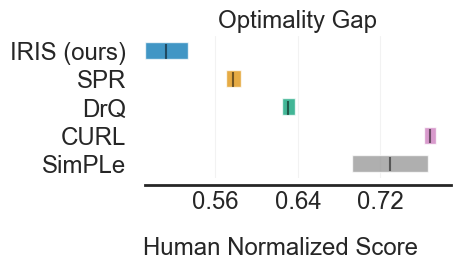

In [30]:
algorithms = ['SimPLe', 'CURL', 'DrQ', 'SPR', 'IRIS (ours)']
fig, axes = plot_utils.plot_interval_estimates(
    {k: v[3:4] for k, v in aggregate_scores.items()}, 
    {k: v[:, 3:4] for k, v in aggregate_interval_estimates.items()},
    metric_names = ['Optimality Gap'],
    algorithms=algorithms,
    colors=ATARI_100K_COLOR_DICT,
    xlabel_y_coordinate=-0.3,
    xlabel='Human Normalized Score')
plt.show()
save_fig(fig, 'optimality_gap')

# Performance profile

In [31]:
algorithms = ['SimPLe', 'CURL', 'DrQ', 'SPR', 'IRIS (ours)']
score_dict = {key: all_score_dict[key] for key in algorithms}
ATARI_100K_TAU = np.linspace(0.0, 8.0, 201)
reps = 2000

score_distributions, score_distributions_cis = rly.create_performance_profile(score_dict, ATARI_100K_TAU, reps=reps)

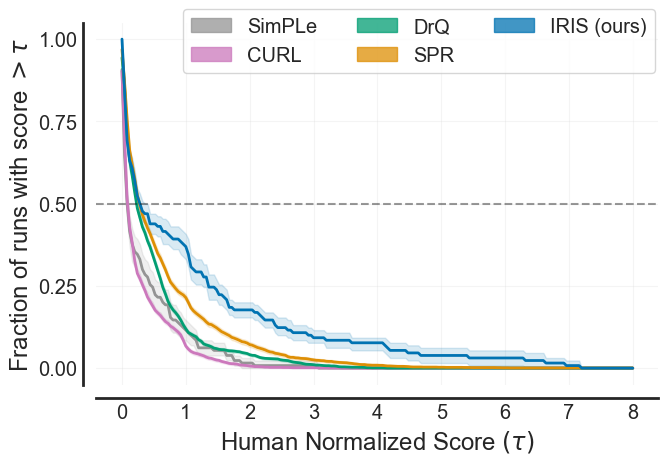

In [32]:
fig, ax = plt.subplots(ncols=1, figsize=(7.25, 4.7))

plot_utils.plot_performance_profiles(
  score_distributions, ATARI_100K_TAU,
  performance_profile_cis=score_distributions_cis,
  colors=ATARI_100K_COLOR_DICT,
  xlabel=r'Human Normalized Score $(\tau)$',
  labelsize='xx-large',
  ax=ax)

ax.axhline(0.5, ls='--', color='k', alpha=0.4)
fake_patches = [mpatches.Patch(color=ATARI_100K_COLOR_DICT[alg], 
                               alpha=0.75) for alg in algorithms]
legend = fig.legend(fake_patches, algorithms, loc='upper center', 
                    fancybox=True, ncol=3, 
                    fontsize='x-large',
                    bbox_to_anchor=(0.57, 0.93))
save_fig(fig, 'performance_profile')

# Probability of improvement

In [33]:
algorithms = ['SimPLe', 'CURL', 'DrQ', 'SPR', 'IRIS (ours)']
our_algorithm = 'IRIS (ours)'
all_pairs =  {}
for alg in (algorithms):
    if alg == our_algorithm:
        continue
    pair_name = f'{our_algorithm}_{alg}'
    all_pairs[pair_name] = (all_score_dict[our_algorithm], all_score_dict[alg]) 

probabilities, probability_cis = {}, {}
reps = 1000
probabilities, probability_cis = rly.get_interval_estimates(all_pairs, metrics.probability_of_improvement, reps=reps)

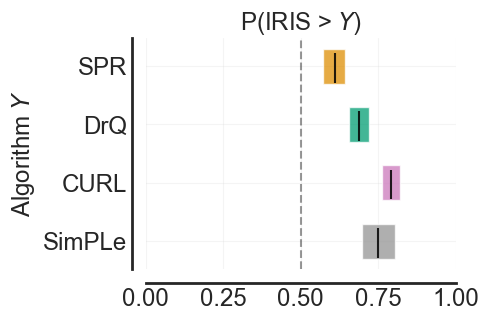

In [34]:
fig, ax = plt.subplots(figsize=(4, 3))
h = 0.6
algorithm_labels = []

for i, (alg_pair, prob) in enumerate(probabilities.items()):
    _, alg1 = alg_pair.split('_')
    algorithm_labels.append(alg1)
    (l, u) = probability_cis[alg_pair]
    ax.barh(y=i, width=u-l, height=h, left=l, color=ATARI_100K_COLOR_DICT[alg1], alpha=0.75)
    ax.vlines(x=prob, ymin=i-7.5 * h/16, ymax=i+(6*h/16), color='k', alpha=0.85)

ax.set_yticks(range(len(algorithm_labels)))
ax.set_yticklabels(algorithm_labels)

ax.set_xlim(0, 1)
ax.axvline(0.5, ls='--', color='k', alpha=0.4)
ax.set_title(fr'P(IRIS > $Y$)', size='xx-large')
plot_utils._annotate_and_decorate_axis(ax, labelsize='xx-large', ticklabelsize='xx-large')
ax.set_ylabel(r'Algorithm $Y$', size='xx-large')
ax.xaxis.set_major_locator(MaxNLocator(4))
fig.subplots_adjust(wspace=0.25, hspace=0.45)
save_fig(fig, 'probability_of_improvement')

# Detailed results

In [35]:
for k in aggregate_scores.keys():
    n_runs, n_games = all_score_dict[k].shape
    assert n_games == 26
    score_dict = score_data_dict_games[k]
    mean, median, iqm, og = aggregate_scores[k]
    sh = np.sum(np.mean(all_score_dict[k], axis=0) >= 1)
    print(f"\n####################\n{k}\n####################\n")
    print(f"{n_runs} runs")
    print(f"#superhuman: {sh}\nMean: {mean:.3f}\nMedian: {median:.3f}\nIQM: {iqm:.3f}\nOptimality gap: {og:.3f}\n")
        
    for game in score_dict.keys():
        h, r = HUMAN_SCORES[game], RANDOM_SCORES[game]
        raw_score = score_dict[game] * (h - r) + r
        print(f"{game}: {np.mean(raw_score): .1f}")


####################
MuZero
####################

1 runs
#superhuman: 5
Mean: 0.562
Median: 0.227
IQM: 0.288
Optimality gap: 0.616

Alien:  530.0
Amidar:  38.8
Assault:  500.1
Asterix:  1734.0
BankHeist:  192.5
BattleZone:  7687.5
Boxing:  15.1
Breakout:  48.0
ChopperCommand:  1350.0
CrazyClimber:  56937.0
DemonAttack:  3527.0
Freeway:  21.8
Frostbite:  255.0
Gopher:  1256.0
Hero:  3095.0
Jamesbond:  87.5
Kangaroo:  62.5
Krull:  4890.8
KungFuMaster:  18813.0
MsPacman:  1265.6
Pong: -6.7
PrivateEye:  56.3
Qbert:  3952.0
RoadRunner:  2500.0
Seaquest:  208.0
UpNDown:  2896.9

####################
EfficientZero
####################

1 runs
#superhuman: 14
Mean: 1.943
Median: 1.090
IQM: 1.047
Optimality gap: 0.367

Alien:  808.5
Amidar:  148.6
Assault:  1263.1
Asterix:  25557.8
BankHeist:  351.0
BattleZone:  13871.2
Boxing:  52.7
Breakout:  414.1
ChopperCommand:  1117.3
CrazyClimber:  83940.2
DemonAttack:  13003.9
Freeway:  21.8
Frostbite:  296.3
Gopher:  3260.3
Hero:  9315.9
Jamesbond:  5

# Generate $\LaTeX$ results table

In [36]:
# Utility to print the latex table

first_row = ["Game", "Random", "Human", "MuZero", "EfficientZero", "SimPLe", "CURL", "DrQ", "SPR", r"\textsc{iris} (ours)"]
rows = [first_row]

# Raw scores

for game in ATARI_100K_GAMES:
    raw_scores = [RANDOM_SCORES[game], HUMAN_SCORES[game]]
    raw_scores.extend([np.mean(score_data_dict_games[algo][game] * (HUMAN_SCORES[game] - RANDOM_SCORES[game]) + RANDOM_SCORES[game]) for algo in aggregate_scores.keys()])
    idx_max_baselines = 4 + np.argmax(raw_scores[4:])
    idx_max_all = 2 + np.argmax(raw_scores[2:])
    raw_scores = [f"{x:.1f}" for x in raw_scores]
    raw_scores[idx_max_baselines] = f"\\textbf{{{raw_scores[idx_max_baselines]}}}"
    raw_scores[idx_max_all] = f"\\underline{{{raw_scores[idx_max_all]}}}"
    row = [game, *raw_scores]
    rows.append(row)

# Aggregates 

first_col = ["\\#Superhuman (↑)", "Mean (↑)", "Median (↑)", "IQM (↑)", "Optimality Gap (↓)"]
cols = [
    [0, 0, 0, 0, 1], # Random
    [float('-inf'), 1, 1, 1, 0], # Human
]
for algo in aggregate_scores.keys():
    n_runs, n_games = all_score_dict[algo].shape
    assert n_games == len(ATARI_100K_GAMES)
    score_dict = score_data_dict_games[algo]
    sh = np.sum(np.mean(all_score_dict[algo], axis=0) >= 1)
    col = [sh, *aggregate_scores[algo]]
    cols.append(col)

rows_ = np.array(cols).T
for i, row in enumerate(rows_):
    idx_best_baselines = 4 + (np.argmin(row[4:]) if i == len(rows_) - 1 else np.argmax(row[4:]))
    idx_best_all = 2 + (np.argmin(row[2:]) if i == len(rows_) - 1 else np.argmax(row[2:]))
    row = [f"{x:.{0 if i == 0 else 3}f}" if not math.isinf(x) else 'N/A' for x in row]
    row[idx_best_baselines] = f"\\textbf{{{row[idx_best_baselines]}}}"
    row[idx_best_all] = f"\\underline{{{row[idx_best_all]}}}"
    rows.append([first_col[i]] + row)
    
    # IQM and OG are N/A for MuZero and EfficientZero.  
    if i >= 3:
        rows[-1][3:5] = ['N/A'] * 2
        #rows[-1][3:5] = 'N/A' 

rows = np.array(rows)
for i in range(rows.shape[1]):
    max_len = max(map(len, rows[:, i])) + 1
    rows[:, i] = list(map(lambda x: x.ljust(max_len), rows[:, i]))

rows = ['  &  '.join(row) for row in rows]

for i, row in enumerate(rows):
    print(row + r'  \\')
    if i in [0, 26]:
        print(r"\midrule")


Game                 &  Random    &  Human     &  MuZero    &  EfficientZero         &  SimPLe                        &  CURL                          &  DrQ                          &  SPR                           &  \textsc{iris} (ours)          \\
\midrule
Alien                &  227.8     &  7127.7    &  530.0     &  808.5                 &  616.9                         &  711.0                         &  \underline{\textbf{865.2}}   &  841.9                         &  420.0                         \\
Amidar               &  5.8       &  1719.5    &  38.8      &  148.6                 &  74.3                          &  113.7                         &  137.8                        &  \underline{\textbf{179.7}}    &  143.0                         \\
Assault              &  222.4     &  742.0     &  500.1     &  1263.1                &  527.2                         &  500.9                         &  579.6                        &  565.6                         &  \underline{\text